## setup

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/needle
# !pip install pybind11
!make clean
!make

rm -rf build python/needle/backend_ndarray/ndarray_backend*.so
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Python: /usr/local/bin/python (found version "3.10.12") found components: Development Interpreter Development.Module Development.Embed 
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Found pybind11: /usr/local/lib/python3.10/dist-packages/pybind11/include (found version "2.12.0")
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  

In [4]:
%set_env PYTHONPATH ./python
%set_env NEEDLE_BACKEND nd

import sys
sys.path.append('./python')

env: PYTHONPATH=./python
env: NEEDLE_BACKEND=nd


In [5]:
import numpy as np
import needle
import needle.nn as nn
from needle.data import Dataset, DataLoader
import glob
import random
from tqdm import tqdm

Using needle backend


## 使用cuda作为NDArray的后端

In [6]:
device = needle.cuda()
print(device)

cuda()


#### **数据集 (CIFAR10Dataset)**

In [7]:
import urllib.request
import os

!mkdir -p './data/ptb'

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

#### **定义 DataLoader**

In [8]:
batch_size = 128

train_dataset = needle.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
test_dataset = needle.data.CIFAR10Dataset("data/cifar-10-batches-py", train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 使用needle定义模型

In [9]:
class ConvBN(nn.Module):
    def __init__(self, a, b, k, s, device=None, dtype="float32") -> None:
        self.a = a
        self.b = b
        self.k = k
        self.s = s

        self.conv2d = nn.Conv(a, b, k, s, device=device, dtype=dtype)
        self.batch_norm = nn.BatchNorm2d(b, device=device, dtype=dtype)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv2d(x)
        x = self.batch_norm(x)
        return self.relu(x)


## currently not implement pooling
## replace pooling with striding
class ResNet18(nn.Module):
    def __init__(self, num_classes, device=None, dtype="float32"):
        super().__init__()
        self.layer1 = nn.Sequential(
            ConvBN(3, 64, 7, 4, device=device, dtype=dtype),
            ConvBN(64, 128, 3, 2, device=device, dtype=dtype),
        )
        self.layer2 = nn.Sequential(
            ConvBN(128, 128, 3, 1, device=device, dtype=dtype),
            ConvBN(128, 128, 3, 1, device=device, dtype=dtype),
        )
        self.layer3 = nn.Sequential(
            ConvBN(128, 256, 3, 2, device=device, dtype=dtype),
            ConvBN(256, 512, 3, 2, device=device, dtype=dtype),
        )
        self.layer4 = nn.Sequential(
            ConvBN(512, 512, 3, 1, device=device, dtype=dtype),
            ConvBN(512, 512, 3, 1, device=device, dtype=dtype),
        )
        self.linear1 = nn.Linear(512, num_classes, device=device, dtype=dtype)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Residual(self.layer2)(x)
        x = self.layer3(x)
        x = nn.Residual(self.layer4)(x)
        x = nn.Flatten()(x)
        x = self.linear1(x)
        return x

## 训练和测试

### 超参数设置

In [10]:
num_classes = 10
num_epochs = 10
learning_rate = 1e-4

model = ResNet18(num_classes=num_classes, device=device)

criterion = nn.SoftmaxLoss()
optimizer = needle.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

### 模型训练


In [11]:
import gc

train_loss_lst = []

model.train()
for epoch in range(num_epochs):
    with tqdm(train_loader, desc='Train [{}/{}]'.format(epoch+1, num_epochs), mininterval=1.0) as t:
        for batch in t:
            images, labels = batch[0].to(device), batch[1].to(device)

            optimizer.reset_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_lst.append(loss.numpy().item())
            t.set_postfix(loss=loss.numpy().item())
            del images, labels, outputs
            gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss.numpy().item()))

Train [1/10]: 391it [01:33,  4.19it/s, loss=1.58]


Epoch [1/10], Loss: 1.5762


Train [2/10]: 391it [01:34,  4.16it/s, loss=1.21]


Epoch [2/10], Loss: 1.2121


Train [3/10]: 391it [01:34,  4.14it/s, loss=0.876]


Epoch [3/10], Loss: 0.8763


Train [4/10]: 391it [01:36,  4.05it/s, loss=0.91]


Epoch [4/10], Loss: 0.9096


Train [5/10]: 391it [01:36,  4.05it/s, loss=0.637]


Epoch [5/10], Loss: 0.6373


Train [6/10]: 391it [01:35,  4.10it/s, loss=0.479]


Epoch [6/10], Loss: 0.4788


Train [7/10]: 391it [01:32,  4.23it/s, loss=0.267]


Epoch [7/10], Loss: 0.2670


Train [8/10]: 391it [01:33,  4.19it/s, loss=0.189]


Epoch [8/10], Loss: 0.1891


Train [9/10]: 391it [01:32,  4.23it/s, loss=0.13]


Epoch [9/10], Loss: 0.1298


Train [10/10]: 391it [01:33,  4.17it/s, loss=0.121]

Epoch [10/10], Loss: 0.1209


### 训练损失曲线可视化


In [12]:
import matplotlib.pyplot as plt


def learning_curve(train_loss_lst, num_epochs, _ylabel1='train loss', smooth_factor=10):
    """
    Args:
        smooth_factor: 平滑因子，只能取正整数。平滑因子越大，损失曲线越平滑
    """

    assert smooth_factor > 0 and type(smooth_factor) == int

    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel(_ylabel1, color=color)
    train_loss_x = list(range(len(train_loss_lst)))
    ax1.plot(train_loss_x[::smooth_factor], train_loss_lst[::smooth_factor], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


========================= LEARNING CURVE =======================


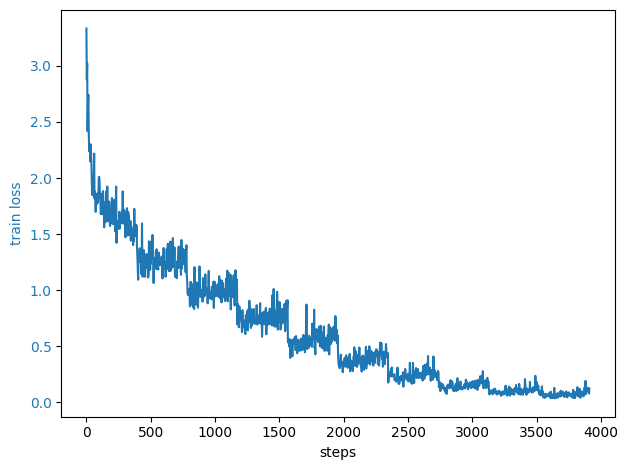

In [13]:
print('========================= LEARNING CURVE =======================')
learning_curve(train_loss_lst, num_epochs, smooth_factor=3)

### 模型测试

In [14]:
model.eval()
correct = 0
total = 0
for images, labels in tqdm(train_loader, desc='Test', mininterval=1.0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    pred = np.argmax(outputs.numpy(), axis=1)

    total += labels.shape[0]
    correct += (pred == labels.numpy()).sum().item()
    del images, labels, outputs

print('Accuracy of the network on the {} train images: {:.4f} %'.format(len(train_dataset), 100 * correct / total))

Test: 391it [00:11, 33.00it/s]

Accuracy of the network on the 50000 train images: 98.9720 %


In [15]:
model.eval()
correct = 0
total = 0
for images, labels in tqdm(test_loader, desc='Test', mininterval=1.0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)

    pred = np.argmax(outputs.numpy(), axis=1)

    total += labels.shape[0]
    correct += (pred == labels.numpy()).sum().item()
    del images, labels, outputs

print('Accuracy of the network on the {} test images: {:.4f} %'.format(len(test_dataset), 100 * correct / total))

Test: 79it [00:02, 36.05it/s]

Accuracy of the network on the 10000 test images: 49.4300 %
